<a href="https://colab.research.google.com/github/Mithil01/Spoken-Digit-Recognition-Using-Augmented-Deep-Learning/blob/main/SpokenDigitRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='red'> Spoken Digit Recognition</font>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,Callback,ModelCheckpoint,TensorBoard
import datetime
%load_ext tensorboard
##if you need any imports you can do that here.

Unzip recordings.zip.

In [3]:
!unzip recordings.zip

Archive:  recordings.zip
   creating: recordings/
  inflating: recordings/0_jackson_0.wav  
  inflating: recordings/0_jackson_1.wav  
  inflating: recordings/0_jackson_10.wav  
  inflating: recordings/0_jackson_11.wav  
  inflating: recordings/0_jackson_12.wav  
  inflating: recordings/0_jackson_13.wav  
  inflating: recordings/0_jackson_14.wav  
  inflating: recordings/0_jackson_15.wav  
  inflating: recordings/0_jackson_16.wav  
  inflating: recordings/0_jackson_17.wav  
  inflating: recordings/0_jackson_18.wav  
  inflating: recordings/0_jackson_19.wav  
  inflating: recordings/0_jackson_2.wav  
  inflating: recordings/0_jackson_20.wav  
  inflating: recordings/0_jackson_21.wav  
  inflating: recordings/0_jackson_22.wav  
  inflating: recordings/0_jackson_23.wav  
  inflating: recordings/0_jackson_24.wav  
  inflating: recordings/0_jackson_25.wav  
  inflating: recordings/0_jackson_26.wav  
  inflating: recordings/0_jackson_27.wav  
  inflating: recordings/0_jackson_28.wav  
  infla

## Creating dataframe

In [4]:
#reading all the files in 'all_files' list and later storing file path and label in a Dataframe
#You can get the label from the first letter of name.
all_files = os.listdir('recordings')
audio_df = pd.DataFrame()
audio_df['path'] = ['recordings/' + f for f in all_files]
audio_df['label'] = [f.split('_')[0] for f in all_files]


## Exploring the sound dataset

In [5]:
#info
audio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


**Shuffling the dataset**

In [6]:
from sklearn.utils import shuffle
audio_df = shuffle(audio_df, random_state=33)

<pre><font size=4>Train and Validation split</font></pre>

In [7]:
#splitting the data into train and validation
#test size of 30%
X_tr, X_te, Y_tr, Y_te = train_test_split(audio_df['path'],audio_df['label'],test_size = 0.3,random_state = 45,stratify = audio_df['label'])

<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [8]:
sample_rate = 22050

def load_wav(x,get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples,sample_rate = librosa.load(x,sr=22050)
    if get_duration:
        duration = librosa.get_duration(y = samples, sr = sample_rate)
        return [samples, duration]
    else:
        return samples

In [38]:
X_tr[:5]

299     recordings/6_jackson_45.wav
331        recordings/1_theo_37.wav
716      recordings/6_nicolas_5.wav
625    recordings/5_yweweler_32.wav
755      recordings/0_nicolas_9.wav
Name: path, dtype: object

In [39]:
## using load_wav function that was written above to get every wave.
X_train_processed, tr_samples, tr_durations = pd.DataFrame(), list(), list()
X_test_processed, te_samples, te_durations = pd.DataFrame(), list(), list()

for f in X_tr.values:
    samples,durations = load_wav(f)
    tr_samples.append(samples)
    tr_durations.append(durations)

for f in X_te.values:
    samples,durations = load_wav(f)
    te_samples.append(samples)
    te_durations.append(durations)

## Converting to a dataframe conataining 'raw_data' and 'duration' as columns
X_train_processed['raw_data'], X_train_processed['duration'] = tr_samples, tr_durations
X_test_processed['raw_data'], X_test_processed['duration'] = te_samples, te_durations


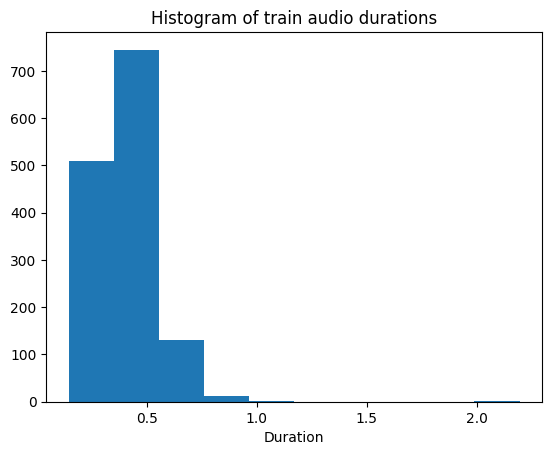

In [11]:
#plot the histogram of the duration for train
import matplotlib.pyplot as plt

plt.hist(X_train_processed.duration)
plt.xlabel('Duration')
plt.title('Histogram of train audio durations')
plt.show()

 **From above one can observe that duration distribution is skewed towards right. In other words, most of train durations are less than 0.8 seconds duration.**

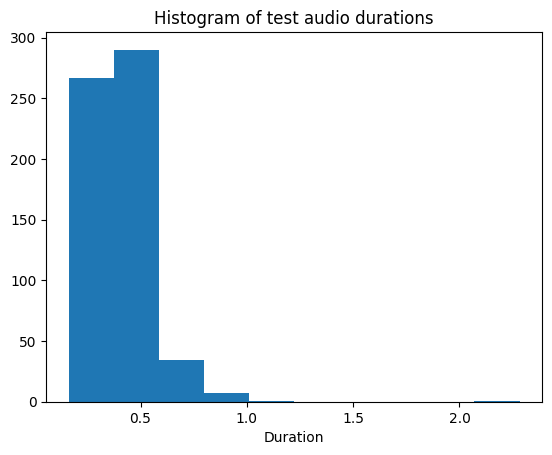

In [12]:
#plot the histogram of the duration for test
plt.hist(X_test_processed.duration)
plt.xlabel('Duration')
plt.title('Histogram of test audio durations')
plt.show()


**Similar to train duraation, even test duration follows same distribution.**

In [13]:
#print 0 to 100 percentile values with step size of 10 for train data duration.
for i in range(0,110,10):
    print(f'{i}th percentile is {np.percentile(X_train_processed.duration,i)}')

0th percentile is 0.1435374149659864
10th percentile is 0.2581269841269841
20th percentile is 0.29777777777777775
30th percentile is 0.3308707482993197
40th percentile is 0.35900226757369613
50th percentile is 0.3896598639455782
60th percentile is 0.41756009070294786
70th percentile is 0.44979138321995465
80th percentile is 0.48757369614512475
90th percentile is 0.5588299319727895
100th percentile is 2.195918367346939


In [14]:
##print 90 to 100 percentile values with step size of 1.
for i in range(90,101,1):
    print(f'{i}th percentile is {np.percentile(X_train_processed.duration,i)}')

90th percentile is 0.5588299319727895
91th percentile is 0.5744204081632656
92th percentile is 0.5829315192743765
93th percentile is 0.6012321995464855
94th percentile is 0.6146947845804989
95th percentile is 0.6269614512471655
96th percentile is 0.6400816326530612
97th percentile is 0.6549514739229024
98th percentile is 0.6823900226757368
99th percentile is 0.7831392290249433
100th percentile is 2.195918367346939



#KEY POINTS:


1.   Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset
2.   While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640 Pad with Zero if length of sequence is less than 17640 else Truncate the number.
3. Creating masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.



In [15]:
max_length  = 17640

In [40]:
## as discussed above, Padding with Zero if length of sequence is less than 17640 else Truncate the number.
X_train_pad_seq = pad_sequences(X_train_processed['raw_data'],maxlen = max_length, padding = 'post',dtype = 'float32', truncating = 'post')
X_test_pad_seq = pad_sequences(X_test_processed['raw_data'],maxlen = max_length,padding = 'post',dtype = 'float32', truncating = 'post')
## Creating masking vector X_train_mask, X_test_mask
X_train_mask = X_train_pad_seq != 0
X_test_mask = X_test_pad_seq != 0
## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.

# Task 1 -  Giving Raw data directly.


---



Steps -



1.  Data :

    *   Train data : X_train_pad_seq, X_train_mask and y_train
    *   Test data: X_test_pad_seq, X_test_mask and y_test
2.  Creating an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input.
3.  Taking the final output of the LSTM and giving it to Dense layer and later feeding it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy(because we are not converting it to one hot vectors).





In [17]:
# Ensuring train and test labels are of type int
Y_tr = Y_tr.values.astype('int')
Y_te = Y_te.values.astype('int')

## Defining Model1 Architecture

In [18]:
rawinput = Input(shape = (17640,1))
mask_input = Input(shape = 17640, dtype = 'bool')
layer_1 = LSTM(50)(rawinput, mask = mask_input)
layer_2 = Dense(50,activation = 'relu', kernel_initializer = 'he_normal')(layer_1)
output = Dense(10, activation = 'softmax', kernel_initializer = 'he_normal' )(layer_2)

model1 = Model(inputs = [rawinput,mask_input], outputs = output)

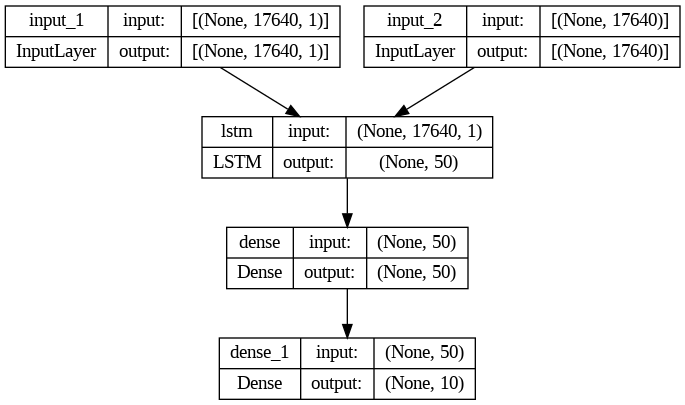

In [19]:
#plotting the MODEL_1 arch
tf.keras.utils.plot_model(model1, show_shapes = True, to_file ="model1.png")

In [20]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17640, 1)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 17640)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 50)           10400       ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 50)           2550        ['lstm[0][0]']               

## Defining Callbacks like
1. Earlystopping - stop training if performance drops below the predefined patience level.
2. Tensorboard - Plotting train and test evaluation metrics. Moreover weights.
3. CustomF1Score class to compute F1Score.

In [41]:

class CustomF1_Score(Callback):
    def __init__(self,train,test):
        self.train_data = (train[0], train[1])
        self.validation_data = (test[0], test[1])
    def on_train_begin(self, logs={}):
        pass
    def on_epoch_end(self, epochs, logs={}):
        #train data
        tr_predict = np.argmax((np.asarray(self.model.predict(self.train_data[0]))).round(),axis = 1)
        tr_target = self.train_data[1]
        #Validation data
        val_predict = np.argmax((np.asarray(self.model.predict(self.validation_data[0]))).round(),axis = 1)
        val_targ = self.validation_data[1]

        #f1_score train
        f1_s_tr = f1_score(tr_target, tr_predict, average = "micro")
        logs["Train_F1_Score"] = f1_s_tr
        #f1_score test
        f1_s = f1_score(val_targ, val_predict, average = "micro")
        logs["Val_F1_Score"] = f1_s

In [42]:
earlystop = EarlyStopping(monitor = "val_loss", min_delta = 1e-5,patience = 5, verbose = 1)

logdir = os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir, histogram_freq = 1, write_graph = True)

f1score_cb = CustomF1_Score(([X_train_pad_seq,X_train_mask],Y_tr),([X_test_pad_seq,X_test_mask],Y_te))

callback_list = [earlystop, tensorboard_callback, f1score_cb]

In [43]:
model1.compile(optimizer='adam',loss='sparse_categorical_crossentropy')

model1.fit([X_train_pad_seq,X_train_mask],Y_tr,validation_data =([X_test_pad_seq,X_test_mask],Y_te),batch_size= 16,epochs=5,callbacks = callback_list)

Epoch 1/5
88/88 [==============================] - 46s 482ms/step - loss: 2.3036 - val_loss: 2.3026 - Train_F1_Score: 0.1000 - Val_F1_Score: 0.1000
Epoch 2/5
88/88 [==============================] - 39s 448ms/step - loss: 2.3029 - val_loss: 2.3026 - Train_F1_Score: 0.1000 - Val_F1_Score: 0.1000
Epoch 3/5
88/88 [==============================] - 39s 448ms/step - loss: 2.3030 - val_loss: 2.3026 - Train_F1_Score: 0.1000 - Val_F1_Score: 0.1000
Epoch 4/5
88/88 [==============================] - 39s 445ms/step - loss: 2.3027 - val_loss: 2.3027 - Train_F1_Score: 0.1000 - Val_F1_Score: 0.1000
Epoch 5/5
88/88 [==============================] - 39s 441ms/step - loss: 2.3068 - val_loss: 2.3029 - Train_F1_Score: 0.1000 - Val_F1_Score: 0.1000


In [44]:
%tensorboard --logdir $logdir

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-08-24 20:49:57.175042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [25]:
!rm -rf ./logs





------------------------------------------------------------------------------------                                                       

## **Task 2**
### **Converting into spectrogram and giving spectrogram data as input**
- Using Librosa library to convert raw data to spectogram. Spectogram converts time domain data to frequency domain data(output will be two-dimensional representation of data)

---





*   Train data: X_train_spectrogram and y_train
*   Test data: X_test_spectrogram and y_test

1.   Creating an LSTM network which takes "X_train_spectrogram" as input and returns output at every time step.
2. Average the output of every time step and give this to the Dense layer of any size.
3. Give the above output to Dense layer of size 10(output layer) and train the network with sparse categorical cross entropy.




In [26]:
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [27]:
## using convert_to_spectrogram and convert every raw sequence in X_train_pad_seq and X_test_pad-seq.

tr_spec,te_spec = list(), list()
for pad_seq in X_train_pad_seq:
    tr_spec.append(convert_to_spectrogram(pad_seq))

for pad_seq in X_test_pad_seq:
    te_spec.append(convert_to_spectrogram(pad_seq))

X_train_spectrogram, X_test_spectrogram = np.array(tr_spec), np.array(te_spec)

In [45]:

print(X_train_spectrogram.shape)
print(Y_tr.shape)
print(X_test_spectrogram.shape)
print(Y_te.shape)

(1400, 64, 35)
(1400,)
(600, 64, 35)
(600,)


## Defining Model_2 Architecture

In [29]:
## Clearing Tensorflow backend
tf.keras.backend.clear_session()
rawinput_2 = Input(shape = (64,35, ))
layer_1 = LSTM(128, return_sequences=True)(rawinput_2)
layer_1_mean = tf.math.reduce_mean(layer_1, axis = -1) # Averaging the output at every time step
layer_2 = Dense(128,activation = 'relu', kernel_initializer = 'he_normal')(layer_1_mean) # passing averaged output to dense layer
output = Dense(10, activation = 'softmax', kernel_initializer = 'he_normal' )(layer_2)

model_2 = Model(inputs = rawinput_2, outputs = output)

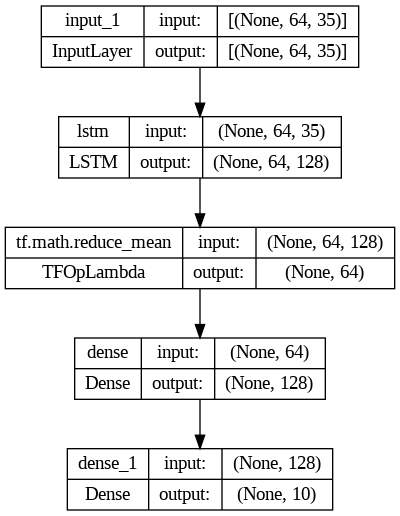

In [30]:
#plotting the MODEL_2 arch
tf.keras.utils.plot_model(model_2, show_shapes = True, to_file ="model_2.png")

In [31]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 128)           83968     
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 64)               0         
 mbda)                                                           
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 93,578
Trainable params: 93,578
Non-trainable params: 0
_________________________________________________________

## Defining Callbacks like


1.   Earlystopping - stop training if performance drops below the predefined patience level.
2.   Tensorboard - Plotting train and test evaluation metrics. Moreover weights.
3.  CustomF1Score class to find F1Score.




In [47]:
earlystop = EarlyStopping(monitor = "val_loss", min_delta = 1e-5,patience = 5, verbose = 1)

logdir = os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir, histogram_freq = 1, write_graph = True)

f1score_cb = CustomF1_Score((X_train_spectrogram,Y_tr),(X_test_spectrogram,Y_te))

callback_list = [earlystop, tensorboard_callback, f1score_cb]

## Compiling and fitting the Model using ADAM optimizer and SparseCategoricalCrossentropy as loss.


In [48]:
model_2.compile(optimizer='adam',loss='sparse_categorical_crossentropy')


model_2.fit(X_train_spectrogram,Y_tr,validation_data =(X_test_spectrogram,Y_te),batch_size= 16,epochs=10,callbacks = callback_list)

Epoch 1/10
 1/88 [..............................] - ETA: 3:03 - loss: 0.5668

88/88 [==============================] - 4s 18ms/step - loss: 0.7158 - val_loss: 0.7393 - Train_F1_Score: 0.6443 - Val_F1_Score: 0.6250
Epoch 2/10
88/88 [==============================] - 1s 10ms/step - loss: 0.6708 - val_loss: 0.6970 - Train_F1_Score: 0.6707 - Val_F1_Score: 0.6417
Epoch 3/10
88/88 [==============================] - 1s 10ms/step - loss: 0.6270 - val_loss: 0.6656 - Train_F1_Score: 0.6993 - Val_F1_Score: 0.6767
Epoch 4/10
88/88 [==============================] - 1s 10ms/step - loss: 0.5869 - val_loss: 0.6473 - Train_F1_Score: 0.7121 - Val_F1_Score: 0.7050
Epoch 5/10
88/88 [==============================] - 1s 10ms/step - loss: 0.5845 - val_loss: 0.6195 - Train_F1_Score: 0.7493 - Val_F1_Score: 0.7233
Epoch 6/10
88/88 [==============================] - 1s 11ms/step - loss: 0.5423 - val_loss: 0.6095 - Train_F1_Score: 0.7557 - Val_F1_Score: 0.7200
Epoch 7/10
88/88 [==============================] - 1s 10ms/step - loss: 0.5316 - val_loss: 0.5677 - Train_F1_Score: 0.7836 - Val

In [51]:

%tensorboard --logdir $logdir

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-08-24 20:51:35.142117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [50]:
!rm -rf ./logs/

# TASK 3 - Data Augmentation with raw features



*   As see from the results of above two models, the model performance did not improve much. That's because model was trained on less data. However, now  we will use data augmentation to increase the data points.

**Data Augmentation techniques**
1. Adding distribution noise to make model more robust.
2. Time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
3. Pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.



In [64]:
## generating augmented data.
def generate_augmented_data(file_path):
    augmented_data = list()
    samples = load_wav(file_path,get_duration=False)
    for time_value in [0.7, 1, 1.3]:
        for pitch_value in [-1, 0, 1]:
            #Adding Noise
            noise_amp = 0.005*np.random.uniform()*np.amax(samples)
            noise = samples.astype('float64') + noise_amp * np.random.normal(size=samples.shape[0])
            # Time stretch
            time_stretch_data = librosa.effects.time_stretch(noise,rate=time_value)
            # Pitch shift
            final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
            augmented_data.append(final_data)
    return augmented_data

## Steps


1.   Split the data.
2.   Perform augmentation on train data using *generate_augmented_data* function and correspondingly augment train labels.
3. Preprocess Test data using *load_wav* function.
4. Perform padding and masking.
5. Fit the model.



In [53]:
X_train, X_test, y_train, y_test = train_test_split(audio_df['path'],audio_df['label'],random_state=45,test_size=0.2,stratify=audio_df['label'])

In [65]:
train_augment, train_labels, test_augment = list(), list(), list()

for tr,y in zip(X_train.values, y_train.values):
  #augmenting train data
  train_augment += generate_augmented_data(tr)
  #augmenting train labels
  train_labels += y*9

for te in X_test.values:
  # preprocessing test data
  test_augment.append(load_wav(te,get_duration = False))

augmented_tr_data = np.array(train_augment)
augmented_test_data = np.array(test_augment)
tr_labels = np.array(train_labels).astype('int')
test_labels = np.array(y_test).astype('int')




<ipython-input-65-d1cca80493c2>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  augmented_tr_data = np.array(train_augment)
<ipython-input-65-d1cca80493c2>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  augmented_test_data = np.array(test_augment)


In [66]:
print(augmented_tr_data.shape)
print(augmented_test_data.shape)
print(tr_labels.shape)
print(test_labels.shape)

(14400,)
(400,)
(14400,)
(400,)


In [67]:
## Padding with Zero if length of sequence is less than 17640 else Truncate the number.
max_length = 17640
X_train_pad_seq = pad_sequences(augmented_tr_data,maxlen = max_length, padding = 'post',dtype = 'float32', truncating = 'post')
X_test_pad_seq = pad_sequences(augmented_test_data,maxlen = max_length,padding = 'post',dtype = 'float32', truncating = 'post')
## Creating masking vector X_train_mask, X_test_mask
X_train_mask = X_train_pad_seq != 0
X_test_mask = X_test_pad_seq != 0

## Defining Callbacks

In [68]:
earlystop = EarlyStopping(monitor = "val_loss", min_delta = 1e-5,patience = 5, verbose = 1)

logdir = os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir, histogram_freq = 1, write_graph = True)

f1score_cb = CustomF1_Score(([X_train_pad_seq,X_train_mask],tr_labels),([X_test_pad_seq,X_test_mask],test_labels))

callback_list = [earlystop, tensorboard_callback, f1score_cb]

## Defining Model3 Architecture

In [69]:
rawinput = Input(shape = (17640,1))
mask_input = Input(shape = 17640, dtype = 'bool')
layer_1 = LSTM(32)(rawinput, mask = mask_input)
layer_2 = Dense(32,activation = 'relu', kernel_initializer = 'he_normal')(layer_1)
output = Dense(10, activation = 'softmax', kernel_initializer = 'he_normal' )(layer_2)

model3 = Model(inputs = [rawinput,mask_input], outputs = output)

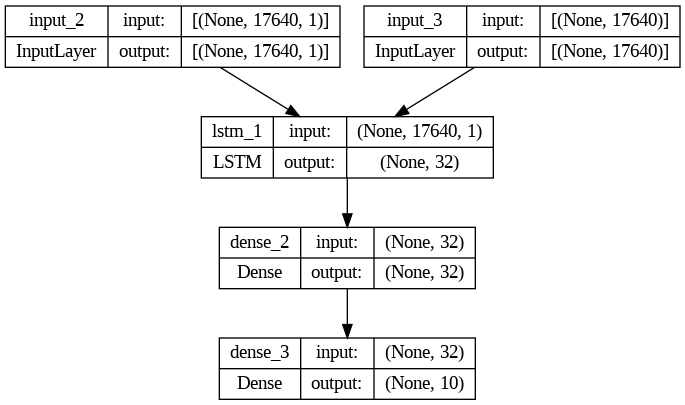

In [70]:
tf.keras.utils.plot_model(model3, show_shapes = True, to_file ="model_3.png")

In [71]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 17640, 1)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 17640)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 32)           4352        ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 32)           1056        ['lstm_1[0][0]']           

## Fitting the Model

In [72]:
model3.compile(optimizer='adam',loss='sparse_categorical_crossentropy')

model3.fit([X_train_pad_seq,X_train_mask],tr_labels,validation_data =([X_test_pad_seq,X_test_mask],test_labels),batch_size= 32,epochs=2,callbacks = callback_list)

Epoch 1/2
450/450 [==============================] - 232s 508ms/step - loss: 2.3030 - val_loss: 2.3026 - Train_F1_Score: 0.1000 - Val_F1_Score: 0.1000
Epoch 2/2
450/450 [==============================] - 224s 497ms/step - loss: 2.3029 - val_loss: 2.3026 - Train_F1_Score: 0.1000 - Val_F1_Score: 0.1000


In [ ]:
model3.fit([X_train_pad_seq,X_train_mask],tr_labels,validation_data =([X_test_pad_seq,X_test_mask],test_labels),batch_size= 32,epochs=3,callbacks = callback_list)

In [73]:
%tensorboard --logdir $logdir

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-08-24 21:21:49.845856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [74]:
!rm -rf ./logs/

# Task 4 - Data augmentation with spectogram data

Steps :


1.  Using convert_to_spectrogram and convert the padded data from train and test data to spectrogram data
2.  Fit the data.



In [75]:
aug_tr_spec, aug_test_spec = list(), list()

## Convert to spectrogram on train data
for pad_seq in X_train_pad_seq:
    aug_tr_spec.append(convert_to_spectrogram(pad_seq))

## Convert to spectogram on test data
for pad_seq in X_test_pad_seq:
    aug_test_spec.append(convert_to_spectrogram(pad_seq))

aug_tr_spec_data = np.array(aug_tr_spec)
aug_test_spec_data = np.array(aug_test_spec)


In [76]:
print(aug_tr_spec_data.shape)
print(aug_test_spec_data.shape)
print(tr_labels.shape)
print(test_labels.shape)

(14400, 64, 35)
(400, 64, 35)
(14400,)
(400,)


## Defining Model 4 Arch

In [77]:
tf.keras.backend.clear_session()
rawinput_4 = Input(shape = (64,35, ))
layer_1 = LSTM(128, return_sequences=True)(rawinput_4)
layer_1_mean = tf.math.reduce_mean(layer_1, axis = -1)
layer_2 = Dense(128,activation = 'relu', kernel_initializer = 'he_normal')(layer_1_mean)
output = Dense(10, activation = 'softmax', kernel_initializer = 'glorot_normal' )(layer_2)

model_4 = Model(inputs = rawinput_4, outputs = output)

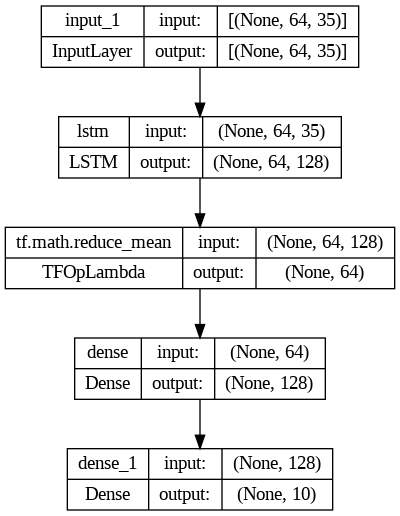

In [78]:
tf.keras.utils.plot_model(model_4, show_shapes = True, to_file ="model_4.png")

In [79]:
model_4.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 128)           83968     
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 64)               0         
 mbda)                                                           
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 93,578
Trainable params: 93,578
Non-trainable params: 0
_________________________________________________________

## Callbacks for Model_4

In [80]:
earlystop = EarlyStopping(monitor = "val_loss", min_delta = 1e-5,patience = 5, verbose = 1)

logdir = os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir, histogram_freq = 1, write_graph = False)

f1score_cb = CustomF1_Score((aug_tr_spec_data,tr_labels),(aug_test_spec_data,test_labels))

callback_list = [earlystop, tensorboard_callback, f1score_cb]

## Model fitting

In [81]:
model_4.compile(optimizer='adam',loss='sparse_categorical_crossentropy')

model_4.fit(aug_tr_spec_data,tr_labels,validation_data =(aug_test_spec_data,test_labels),batch_size= 64,epochs=10,callbacks = callback_list)

Epoch 1/10
225/225 [==============================] - 6s 17ms/step - loss: 1.5311 - val_loss: 0.9132 - Train_F1_Score: 0.4547 - Val_F1_Score: 0.4475
Epoch 2/10
225/225 [==============================] - 3s 12ms/step - loss: 0.7560 - val_loss: 0.5548 - Train_F1_Score: 0.7249 - Val_F1_Score: 0.7675
Epoch 3/10
225/225 [==============================] - 3s 11ms/step - loss: 0.5604 - val_loss: 0.4124 - Train_F1_Score: 0.8058 - Val_F1_Score: 0.8525
Epoch 4/10
225/225 [==============================] - 3s 12ms/step - loss: 0.4661 - val_loss: 0.3904 - Train_F1_Score: 0.8155 - Val_F1_Score: 0.8625
Epoch 5/10
225/225 [==============================] - 3s 12ms/step - loss: 0.4305 - val_loss: 0.3619 - Train_F1_Score: 0.8337 - Val_F1_Score: 0.8625
Epoch 6/10
225/225 [==============================] - 3s 12ms/step - loss: 0.3795 - val_loss: 0.2877 - Train_F1_Score: 0.8635 - Val_F1_Score: 0.8975
Epoch 7/10
225/225 [==============================] - 3s 12ms/step - loss: 0.3617 - val_loss: 0.3066 - Tra

In [82]:
%tensorboard --logdir $logdir

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-08-24 21:27:37.891923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.